<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [77]:
# pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [78]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
scipy 0.19.1
pandas 0.22.0
matplotlib 2.1.2
statsmodels 0.8.0
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : 3896ce11e3ff803864dd6294ff5e80e874b7ba3d


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

In [6]:
X_sparse_10users.shape #mine

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [12]:
scores_train = cross_val_score(knn, X_train, y_train, cv=skf)
score_train = scores_train.mean()
score_train

0.5647188870063362

In [13]:
knn.fit(X_train, y_train)
score_valid = knn.score(X_valid, y_valid)
score_valid

0.584024650391088

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [14]:
# Функция сохранения в файл ответа, представленного массивом
def write_answer_to_file(array, fname):
    with open(fname,"w") as fout:
        fout.write(" ".join([str(el) for el in array]))

In [15]:
print(round(score_train, 3), round(score_valid, 3))

0.565 0.584


In [16]:
write_answer_to_file([round(score_train, 3), round(score_valid, 3)],
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [19]:
forest_train = forest.oob_score_
forest_train

0.7225157488315384

In [20]:
forest_valid = forest.score(X_valid, y_valid)

In [21]:
print(round(forest_train, 3), round(forest_valid, 3))

0.723 0.735


In [22]:
write_answer_to_file([round(forest_train, 3), round(forest_valid, 3)],
                     'answer4_2.txt')

In [23]:
#!cat answer4_2.txt #hangs on my win10

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [32]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [33]:
logit_scores_train = cross_val_score(logit, X_train, y_train, cv=skf)
logit_score_train = scores_train.mean()
logit_score_train

0.5647188870063362

In [34]:
logit.fit(X_train, y_train)
logit_score_valid = logit.score(X_valid, y_valid)
logit_score_valid

0.7817018250770325

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [36]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, random_state=17, n_jobs=-1, cv=skf, multi_class='multinomial')
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 19.2 s


In [39]:
logit_c_values1

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [63]:
#If the ‘multi_class’ option given is ‘multinomial’ then 
#the same scores are repeated across all classes, since this is the multinomial class
logit_mean_cv_scores1 = logit_grid_searcher1.scores_.get(31).mean(axis=0)
logit_mean_cv_scores1

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75919919, 0.75655945, 0.75036202, 0.73888041])

In [74]:
logit_grid_searcher1.C_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [64]:
index = np.argmax(logit_mean_cv_scores1)
print(logit_mean_cv_scores1[index], logit_c_values1[index])

0.7591991869143073 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

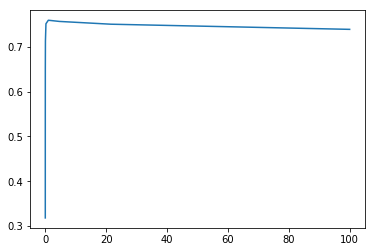

In [65]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [66]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, random_state=17, n_jobs=-1, cv=skf, multi_class='multinomial')
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [67]:
print(logit_c_values2)
logit_mean_cv_scores2 = logit_grid_searcher2.scores_.get(31).mean(axis=0)
logit_mean_cv_scores2

[0.1        0.46315789 0.82631579 1.18947368 1.55263158 1.91578947
 2.27894737 2.64210526 3.00526316 3.36842105 3.73157895 4.09473684
 4.45789474 4.82105263 5.18421053 5.54736842 5.91052632 6.27368421
 6.63684211 7.        ]


array([0.7354267 , 0.75879135, 0.75838615, 0.75767464, 0.75818317,
       0.75838717, 0.75808238, 0.75747318, 0.75706727, 0.75676347,
       0.75716964, 0.75676347, 0.75595074, 0.75574774, 0.75513903,
       0.75473337, 0.75483549, 0.75483549, 0.75432754, 0.75392104])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [68]:
index = np.argmax(logit_mean_cv_scores2)
print(logit_mean_cv_scores2[index], logit_c_values2[index])

0.7587913513956875 0.4631578947368421


In [75]:
logit_grid_searcher2.C_

array([0.46315789, 0.46315789, 0.46315789, 0.46315789, 0.46315789,
       0.46315789, 0.46315789, 0.46315789, 0.46315789, 0.46315789])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

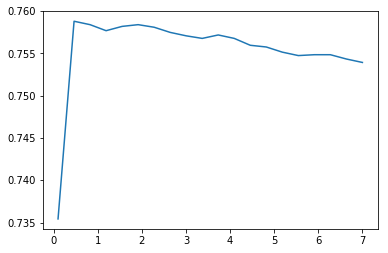

In [69]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [73]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7748281583313581

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [79]:
logit_grid2_scores_train = cross_val_score(logit_grid_searcher2, X_train, y_train, cv=skf)
logit_grid2_score_train = logit_grid2_scores_train.mean()
logit_grid2_score_train

0.7573693909666952

In [80]:
write_answer_to_file([round(logit_grid2_score_train, 3), round(logit_cv_acc, 3)],
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [81]:
from sklearn.svm import LinearSVC

In [83]:
svm = LinearSVC(C=1, random_state=17)

In [84]:
svm_scores_train = cross_val_score(svm, X_train, y_train, cv=skf)
svm_score_train = svm_scores_train.mean()
svm_score_train

0.7527976723012523

In [86]:
svm.fit(X_train, y_train)
svm_score_test = svm.score(X_valid, y_valid)
svm_score_test

0.7769613652524295

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [87]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 39.5 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [94]:
''' ВАШ КОД ЗДЕСЬ '''
print(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_estimator_)

0.692237350132087 LinearSVC(C=3333.3334000000004, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

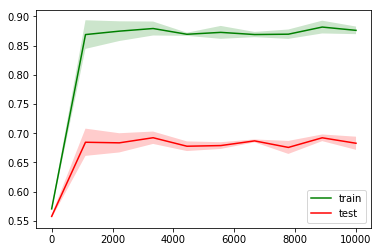

In [88]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [95]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 13s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [96]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_estimator_)

0.7661044503149766 LinearSVC(C=0.13879310344827586, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

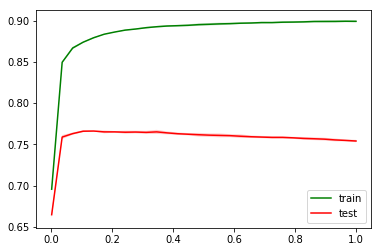

In [97]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [98]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.7817018250770325

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [99]:
write_answer_to_file([round(svm_grid_searcher2.best_score_, 3), round(svm_cv_acc, 3)],
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [138]:
import time

def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start = time.time()
    with open(path_to_X_pickle, 'rb') as X_sparse_10users_pkl:
        X_sparse = pickle.load(X_sparse_10users_pkl)
    with open(path_to_y_pickle, 'rb') as y_10users_pkl:
        y = pickle.load(y_10users_pkl)
    print("SHAPE:", X_sparse.shape, y.shape)  
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                    test_size=test_size, random_state=random_state, stratify=y)
    
    print("Split shape:", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

    cv_score = cross_val_score(estimator, X_train, y_train, cv=cv).mean()    
    y_predict = estimator.predict(X_valid)
    
    holdout_score = accuracy_score(y_valid, y_predict)
    return (cv_score, holdout_score, (time.time() - start))

**Убедитесь, что функция работает.**

In [139]:
%%time
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

SHAPE: (14061, 4913) (14061,)
Split shape: (9842, 4913) (9842,) (4219, 4913) (4219,)
Wall time: 1.96 s


(0.7633649590115557, 0.7817018250770325, 1.9565691947937012)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [102]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [134]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s{session_length}_w{window_size}.pkl')
        (cv, hold, t) = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print(f"s:{session_length}", f"w:{window_size}", f"cv score:{cv}", f"holdout_score:{hold}", f"time:{t}")

SHAPE: (14061, 4913) (14061,)
Split shape: (9842, 4913) (9842,) (4219, 4913) (4219,)
Expected shape: (4219,) Predicted shape: (4219,)
s:15 w:10 cv score:0.8217896546706148 holdout_score:0.8307655842616734 time:3.1757609844207764
SHAPE: (14061, 4913) (14061,)
Split shape: (9842, 4913) (9842,) (4219, 4913) (4219,)
Expected shape: (4219,) Predicted shape: (4219,)
s:10 w:10 cv score:0.7633649590115557 holdout_score:0.7817018250770325 time:1.679896354675293
SHAPE: (20087, 4913) (20087,)
Split shape: (14060, 4913) (14060,) (6027, 4913) (6027,)
Expected shape: (6027,) Predicted shape: (6027,)
s:15 w:7 cv score:0.8470874683536852 holdout_score:0.863447818151651 time:4.736433982849121
SHAPE: (20087, 4913) (20087,)
Split shape: (14060, 4913) (14060,) (6027, 4913) (6027,)
Expected shape: (6027,) Predicted shape: (6027,)
s:10 w:7 cv score:0.7975853695418165 holdout_score:0.8324207731873237 time:2.742100954055786
SHAPE: (20087, 4913) (20087,)
Split shape: (14060, 4913) (14060,) (6027, 4913) (6027,)

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [120]:
write_answer_to_file([round(0.8689670755674888, 3), round(0.8691322901849218, 3)],
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [145]:
# not recommended to use, takes hours and hours
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
    X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_150users, y_150users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_150users)
#svm_params3 = {'C': np.linspace(1e-3, 1, 30)}

#svm_grid_searcher3 = GridSearchCV(svm, svm_params3, n_jobs=-1)
#svm_grid_searcher3.fit(X_train, y_train)

#estimator = svm_grid_searcher3.best_estimator_

In [146]:
%%time
estimator = LinearSVC(C=0.13879310344827586, random_state=17)
estimator.fit(X_train, y_train)

for window_size, session_length in [(10,10)]:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_150users_s{session_length}_w{window_size}.pkl')
        (cv, hold, t) = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print(f"s:{session_length}", f"w:{window_size}", f"cv score:{cv}", f"holdout_score:{hold}", f"time:{t}")

SHAPE: (137019, 27797) (137019,)
Split shape: (95913, 27797) (95913,) (41106, 27797) (41106,)
s:10 w:10 cv score:0.46131133117144474 holdout_score:0.48447915146207365 time:269.0458962917328
Wall time: 7min 13s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [147]:
write_answer_to_file([round(0.46131133117144474, 3), round(0.48447915146207365, 3)],
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [148]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [149]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [176]:
print(logit_grid_searcher2.C_[0])
print(logit_grid_searcher2.Cs_[10])

0.4631578947368421
3.7315789473684213


In [190]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], random_state=17, n_jobs=-1, multi_class='ovr', cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 7min 8s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [191]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:    
    #scores is a dict where key is user and value is scores?
    mean = logit_cv_150users.scores_[user_id].mean()
    cv_scores_by_user[user_id] = mean
    print(f'User {user_id}, CV score: {mean}')

User 6, CV score: 0.9958396485310578
User 13, CV score: 0.996236159606072
User 15, CV score: 0.9951414156621485
User 16, CV score: 0.9917629636028263
User 28, CV score: 0.990032646749408
User 31, CV score: 0.9945992933895361
User 33, CV score: 0.9936295923347456
User 39, CV score: 0.9857474441964414
User 46, CV score: 0.9979773735144889
User 49, CV score: 0.9949328849394247
User 50, CV score: 0.9944847392709221
User 53, CV score: 0.9936087227963695
User 65, CV score: 0.9969973347781819
User 66, CV score: 0.9949640742212859
User 82, CV score: 0.9963612639936241
User 85, CV score: 0.9963196987839488
User 89, CV score: 0.9905122649916512
User 92, CV score: 0.9943596252032839
User 100, CV score: 0.9947138940123931
User 102, CV score: 0.991190153815365
User 103, CV score: 0.9798572049408728
User 105, CV score: 0.9968201105460203
User 106, CV score: 0.9945051894225921
User 118, CV score: 0.9906581115547454
User 119, CV score: 0.9966011573912393
User 120, CV score: 0.9942028893690901
User 126

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [192]:
class_distr = np.bincount(y_train_150.astype('int'))
all = np.sum(class_distr)

acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (all - class_distr[user_id])/len(y_train_150)

In [193]:
acc_diff_vs_constant

{6: 0.011437117070254743,
 13: 0.0005317191235514329,
 15: 0.0007402395963388431,
 16: 0.007047648682012686,
 28: 0.002085236075151209,
 31: 0.0001459867470580134,
 33: 0.0010842647983323461,
 39: 0.001834940156321796,
 46: 0.0008549813465866807,
 49: 0.0011051452169678067,
 50: 0.00033378997312094594,
 53: 0.001563848795973266,
 65: 7.303880161979581e-05,
 66: 0.00010414908079392493,
 82: 1.0404360414884017e-05,
 85: 0.0001252308807447866,
 89: 0.00043792678932208506,
 92: 0.00020867590548279136,
 100: -3.1343859428267784e-05,
 102: 0.0007509015763567106,
 103: 0.0028572153669881306,
 105: 0.0008028866034890392,
 106: 0.007287606821693382,
 118: 0.0006567561597520255,
 119: 0.0006569162560439157,
 120: 0.0005419674919722173,
 126: 0.0009382524059680097,
 127: 0.0035551118448688968,
 128: 0.00498392170365769,
 138: 8.337290556748034e-05,
 158: 0.0002711475130222629,
 160: 0.00032312763440156544,
 165: 0.00021895633115565083,
 172: 0.00028152902094791266,
 177: 0.00034413642443709147,
 

In [194]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

In [195]:
print(round(num_better_than_default / len(np.unique(y_train_150)), 3))

0.913


**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [187]:
write_answer_to_file([round(num_better_than_default / len(np.unique(y_train_150)), 3)], 'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [188]:
y_binary_128 = (y_train == 128).astype(int)

In [189]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [199]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = logit_cv_150users
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary_128, train_sizes=train_sizes, cv=skf)

Wall time: 4min 19s


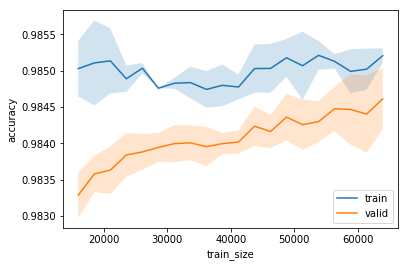

In [200]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.